In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from warnings import filterwarnings
filterwarnings("ignore")

In [64]:

cf  = pd.read_csv("data_intermediate/customer_features.csv")
rfm = pd.read_csv("data_intermediate/rfm_analysis.csv")

In [65]:
cf.head()

,MEMBER_ID,total_orders,total_items,total_units,gross_product_spend,order_adj_total,shipping_total,tax_total,unique_products,unique_types,...,top_type,top_type_share,REGISTERTYPE,LASTORDER,REGISTRATION,LASTSESSION,REGISTRATIONUPDATE,LOGONID,EMAIL,NAME
0,3003,2,2,2,100.0,-10.00,0.00,0.0,1,1,...,ItemBean,1.0,R,2025-11-20,2025-11-20,2025-11-20,2025-11-20,pkumar,pkumar@solveda.com,Pranav Kumar
1,4002,2,2,2,255.0,-27.38,11.88,0.0,2,1,...,ItemBean,1.0,R,2025-11-25,2025-11-21,2025-11-25,2025-11-21,robertdowneyjr1@yopmail.com,robertdowneyjr1@yopmail.com,Robert Downey Jr
2,4003,1,3,3,3342.0,-191.76,86.76,0.0,3,1,...,ItemBean,1.0,R,2025-11-21,2025-11-21,2025-11-21,2025-11-21,johnchambers@yopmail.com,johnchambers@yopmail.com,John Chambers
3,4004,2,12,12,16256.0,-467.96,162.36,0.0,11,1,...,ItemBean,1.0,R,2025-11-21,2025-11-21,2025-11-21,2025-11-21,andymurray@yopmail.com,andymurray@yopmail.com,Andy Murray
4,4005,2,3,3,319.0,-36.70,19.80,0.0,3,1,...,ItemBean,1.0,R,2025-11-21,2025-11-21,2025-11-21,2025-11-21,michaels@yopmail.com,michaels@yopmail.com,Michael S


In [66]:
rfm.head()

,MEMBER_ID,recency,frequency,monetary,R,F,M,RFM_score,state_segment
0,3003,11,2,90.00,1,1,1,1.000000,Churned
1,4002,6,2,227.62,1,1,2,1.333333,Churned
2,4003,10,1,3150.24,1,1,4,2.000000,Churned
3,4004,10,2,15788.04,1,1,4,2.000000,Churned
4,4005,10,2,282.30,1,1,3,1.666667,Churned


In [67]:

# # merge tables
# data = cf.merge(rfm[["MEMBER_ID","state_segment","recency", "frequency", "monetary"]], on="MEMBER_ID", how="left")

# # Check available columns
# data.columns

# # select required columns
# feature_cols = [
#     "recency", "frequency", "monetary",
#     "avg_order_value", "avg_units_per_order",
#     "promo_orders", "promo_adj_total",
#     "unique_products", "unique_types",
#     "shipping_ratio",
#     "top_type_share"
# ]

In [68]:
# ensure cols exist + clean
X = rfm[["recency", "frequency", "monetary"]].replace([np.inf,-np.inf], np.nan).fillna(0.0)

# scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
# pick k using silhouette + inertia
scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, init='k-means++', n_init=1000, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    scores.append((k, sil, km.inertia_))

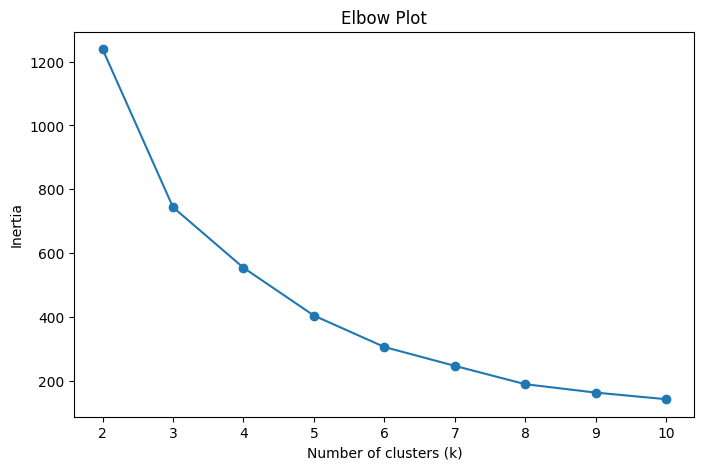

In [70]:
# elbow plot for checking optimal k using inertia score
plt.figure(figsize=(8,5))
plt.plot([s[0] for s in scores], [s[2] for s in scores], marker='o')
plt.title("Elbow Plot")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

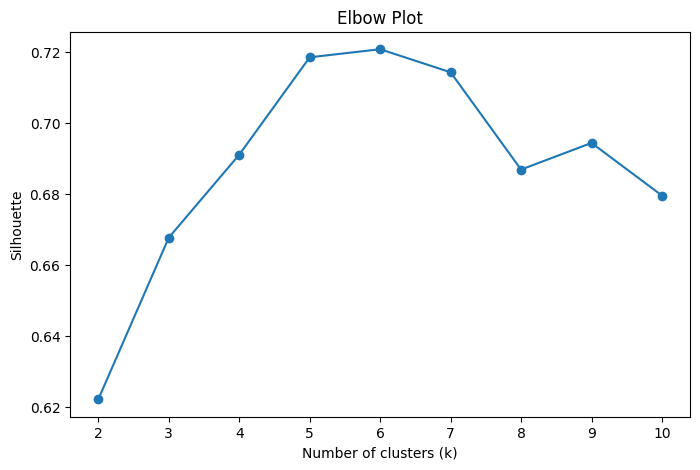

In [71]:
# elbow plot for checking optimal k using silhouette score
plt.figure(figsize=(8,5))
plt.plot([s[0] for s in scores], [s[1] for s in scores], marker='o')
plt.title("Elbow Plot")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette")
plt.show()

The plots don't offer a proper idea on the optimal number of clusters. For a better clarification, we do a **cluster stability test** for validation on the optimal number of clusters among **k = 3, 4, 5, 6, 7**.

In [72]:
# create functions for fitting model and stability calculation
def fit_kmeans(df, k, seed=42):
    return KMeans(n_clusters=k, n_init=100, init='k-means++', random_state=seed).fit(df)

def cluster_stability(df, k, n_runs=20, sample_frac=0.8):
    n = df.shape[0]
    
    # reference clustering
    ref_labels = fit_kmeans(df, k).labels_
    
    test_scores = []
    
    for i in range(n_runs):
        idx = np.random.choice(n, int(sample_frac * n), replace=False)
        df_sub = df[idx]
        
        sub_model = fit_kmeans(df_sub, k, seed=i)
        sub_labels = sub_model.labels_
        
        # compare only on overlapping points
        test_scores.append(
            adjusted_rand_score(ref_labels[idx], sub_labels)
        )
        
    return np.mean(test_scores), np.std(test_scores)

In [73]:
# define the subset of clusters bassed on elbow plots
test_clusters = [i for i in range(3, 8)]

# compute stability for each k
results = {}

for k in test_clusters:
    mean_ari, std_ari = cluster_stability(X_scaled, k)
    results[k] = (mean_ari, std_ari)
    print(f"k={k}: ARI={mean_ari:.3f} ± {std_ari:.3f}")

k=3: ARI=0.998 ± 0.003
k=4: ARI=0.994 ± 0.021
k=5: ARI=0.995 ± 0.012
k=6: ARI=0.982 ± 0.040
k=7: ARI=0.941 ± 0.086


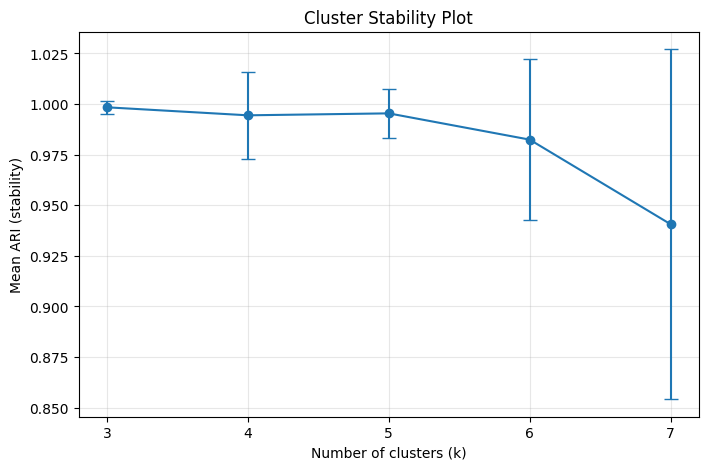

In [74]:
plt.figure(figsize=(8, 5))

mean_aris = [results[k][0] for k in test_clusters]
std_aris = [results[k][1] for k in test_clusters]

plt.errorbar(
    test_clusters,
    mean_aris,
    yerr=std_aris,
    fmt='o-',
    capsize=5
)

plt.xlabel("Number of clusters (k)")
plt.ylabel("Mean ARI (stability)")
plt.title("Cluster Stability Plot")
plt.xticks(test_clusters, [int(k) for k in test_clusters])
plt.grid(True, alpha=0.3)

plt.show()

From this test, we wanted to check which is the best clustering number that is stable despite small data perturbations. Comparing the Adjusted Rand Index (ARI) scores of all the clusters, we can see that it is peaking at **k = 5** clusters, making it the most optimal clustering value for our case.

In [75]:
# fit and predict the final model with k = 5 clusters
final_km = KMeans(n_clusters=5, init='k-means++', n_init=1000, random_state=42)
rfm['cluster'] = final_km.fit_predict(X_scaled) + 1  # to make cluster labels start from 1

In [76]:
# combine cf and rfm tables for analysis and profiles table
final = cf.merge(rfm[["MEMBER_ID","recency","frequency","monetary","cluster"]], on="MEMBER_ID", how="left")
            
cluster_analysis = final.groupby("cluster").agg(
    customer_count=("MEMBER_ID","count"),
    avg_recency=("recency","mean"),
    avg_frequency=("frequency","mean"),
    avg_monetary=("monetary","mean"),
    avg_order_value=("avg_order_value","mean"),
    avg_units_per_order=("avg_units_per_order","mean"),
    promo_orders=("promo_orders","mean"),
    promo_adj_total=("promo_adj_total","mean"),
    unique_products=("unique_products","mean"),
    unique_types=("unique_types","mean"),
    shipping_ratio=("shipping_ratio","mean"),
    top_type_share=("top_type_share","mean"),
)

profiles = final[["MEMBER_ID","NAME","LOGONID","EMAIL","recency","frequency","monetary","cluster"]]

In [77]:
# names map
cluster_names = {
    1: "Dormant Buyers",
    2: "Core Customers",
    3: "Loyal Customers",
    4: "Premium Buyers",
    5: "Champions"
}

# Build MultiIndex: [cluster(number), cluster_name]
idx = cluster_analysis.index.astype(int)
cluster_analysis.index = pd.MultiIndex.from_arrays(
    [idx, idx.map(cluster_names)],
    names=["cluster", "cluster_name"]
)

# profiles with name column (ensure int type for mapping)
profiles = final[["MEMBER_ID","NAME","LOGONID","EMAIL","recency","frequency","monetary","cluster"]]
profiles["cluster"] = profiles["cluster"].astype(int)
profiles["cluster_name"] = profiles["cluster"].map(cluster_names)

# Preserve both cluster and cluster_name
cluster_analysis_reset = cluster_analysis.reset_index()

In [78]:
# cluster level analysis
cluster_analysis.head()

,,customer_count,avg_recency,avg_frequency,avg_monetary,avg_order_value,avg_units_per_order,promo_orders,promo_adj_total,unique_products,unique_types,shipping_ratio,top_type_share
cluster,cluster_name,,,,,,,,,,,,
1,Dormant Buyers,438,3.000000,3.920091,316.479795,80.862301,1.000571,1.0,-81.925297,1.002283,1.0,0.153857,1.0
2,Core Customers,18,3.388889,5.333333,6342.715556,1465.113083,1.333333,1.0,-328.234444,2.000000,1.0,0.005214,1.0
3,Loyal Customers,167,0.000000,5.724551,498.115210,88.894628,1.053892,1.0,-115.590419,1.005988,1.0,0.094487,1.0
4,Premium Buyers,13,8.846154,1.769231,579.855385,401.467179,1.679487,1.0,-53.320000,2.923077,1.0,0.054172,1.0
5,Champions,31,2.612903,8.258065,771.485161,95.748362,1.018945,1.0,-165.214839,2.322581,1.0,0.152694,1.0


In [79]:
# final segregation of customer profiles by clusters
profiles.head()

,MEMBER_ID,NAME,LOGONID,EMAIL,recency,frequency,monetary,cluster,cluster_name
0,3003,Pranav Kumar,pkumar,pkumar@solveda.com,11,2,90.00,4,Premium Buyers
1,4002,Robert Downey Jr,robertdowneyjr1@yopmail.com,robertdowneyjr1@yopmail.com,6,2,227.62,4,Premium Buyers
2,4003,John Chambers,johnchambers@yopmail.com,johnchambers@yopmail.com,10,1,3150.24,4,Premium Buyers
3,4004,Andy Murray,andymurray@yopmail.com,andymurray@yopmail.com,10,2,15788.04,2,Core Customers
4,4005,Michael S,michaels@yopmail.com,michaels@yopmail.com,10,2,282.30,4,Premium Buyers


In [80]:
final.to_csv("outputs/final_output.csv", index=False)
cluster_analysis_reset.to_csv("outputs/cluster_analysis.csv", index=False)
profiles.to_csv("outputs/cluster_profiles.csv", index=False)